In [1]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

# Wordcloud
from wordcloud import WordCloud

# # Pil
# from PIL import Image

# Json
import json


import mlflow

# # Emoji
# import emoji

# import re

# import string

# Sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

# # NLTK
# import nltk
# from nltk import ngrams
# from nltk.util import trigrams
# from nltk.util import bigrams
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.tokenize import word_tokenize, wordpunct_tokenize
# from nltk.corpus import words
# from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer
# from nltk.tokenize.treebank import TreebankWordDetokenizer
# import nlp

# Keras
# from keras_preprocessing.sequence import pad_sequences


# Pyldavis
import pyLDAvis
import pyLDAvis.gensim_models

# Collections
import collections

# Itertools
import itertools

# Gensim
# import gensim
# from gensim import corpora, models, similarities
# from gensim.models.coherencemodel import CoherenceModel

# Transformers
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig

# Torch
# import torch
# import torch.nn.functional as F

# # Image
# from IPython.display import Image

# # Punctuation
# from string import punctuation

# # time
# import time

# Gc
import gc

# Functions notebook
from functions.functions import *

c:\Users\romai\anaconda3\envs\P07\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

c:\Users\romai\Desktop\OC_Romain_Vairo\P7_VAIRO_ROMAIN\functions\functions.py:144: DeprecationWarning:

invalid escape sequence \S



# <center><a id='loading'>Chargement du dataframe</a></center>

In [2]:
data = pd.read_csv("csv/data_40000.csv")

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

# DistilBERT

In [3]:
X = data["tweet"].loc[pd.isna(data["target"])==False]
Y = data["target"].loc[pd.isna(data["target"])==False]

In [4]:
X_train_base, X_test, y_train_base, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [6]:
train_encodings = tokenizer(X_train_base.to_list(), truncation=True, padding=True, return_tensors='np').data

In [7]:
test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True, return_tensors='np').data

In [8]:
X_train_ids, X_val_ids, X_train_att, X_val_att, y_train, y_val = train_test_split(train_encodings["input_ids"],train_encodings["attention_mask"], y_train_base, test_size=0.3, random_state=20)

In [9]:
X_train_ids, X_test_ids, X_train_att, X_test_att, y_train, y_test = train_test_split(train_encodings["input_ids"],train_encodings["attention_mask"], y_train_base, test_size=0.3, random_state=20)

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

In [10]:
dropout_distillbert = 0.2 # 0.2
attention_distillbert_dropout = 0.2 # 0.2
 
# Configuration et initialisation du DistilBERT
config = DistilBertConfig(dropout=dropout_distillbert, 
                          attention_dropout=attention_distillbert_dropout, 
                          output_hidden_states=True)
                          
# Modèle DistillBERT pré-entraîné
distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Fait en sorte que les couches de DistillBERT ne soit pas entraînable
for layer in distilbert.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [11]:
max_length = 84 # 50
# learning_rate = 5e-3 # 0.000003 3e-5 # 0.008
random_state = 42

def model_builder(transformer, max_length=max_length):
    """
    Construction du modèle BERT pour pouvoir ensuite entraîner les données
    """
    
    # Définition de l'initialisateur de poids avec le random seed pour pouvoir reproduire le model
    initialization_weight = tf.keras.initializers.GlorotNormal(seed=random_state) 
    
    # Définition des couches inputs et attention mask
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    
    # Génération d'un tuple ou le premier élément est à l'index 0
    # représente le hidden-state à la sortie de la couche final du modèle
    last_hid_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # Le jeton CLS se trouve à l'index 0 de chacune des séquences encodée, le découpage du jeton CLS, donne des données en 2 dimensions
    token_cls = last_hid_state[:, 0, :]
    
    ## Définitions des couches 
    output_layer = tf.keras.layers.Dense(1, # 2
                                   activation='sigmoid', # softmax
                                   kernel_initializer=initialization_weight,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(token_cls)
    
    # Définition du modèle
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output_layer)
    
    # Compilation du modèle
    model.compile(tf.keras.optimizers.Adam(), # lr=learning_rate  learning_rate=learning_rate
                  loss=tf.keras.losses.BinaryFocalCrossentropy(),  # from_logits=True
                  metrics=['accuracy','AUC']) 
    
    return model

In [12]:
model = model_builder(distilbert)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 84)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 84)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 84, 768),                                                    
                                 hidden_states=((No                                           

In [14]:
epochs = 2      # 10
batch_size = 8 # 16

start = time.time()
history = model.fit(
    x = [X_train_ids, X_train_att],
    y = y_train.to_numpy(),
    epochs = epochs,
    batch_size = batch_size,
    validation_data = ([X_val_ids, X_val_att], y_val.to_numpy()),
)
stop = time.time()

Epoch 1/2
2450/2450 [==============================] - 1283s 522ms/step - loss: 0.1436 - accuracy: 0.7068 - auc: 0.7805 - val_loss: 0.1232 - val_accuracy: 0.7714 - val_auc: 0.8540
Epoch 2/2
2450/2450 [==============================] - 1282s 523ms/step - loss: 0.1357 - accuracy: 0.7381 - auc: 0.8133 - val_loss: 0.1223 - val_accuracy: 0.7698 - val_auc: 0.8559


<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

In [15]:
tableau_score = pd.read_csv("csv/tableau_score.csv")

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

263/263 [==============================] - 298s 1s/step


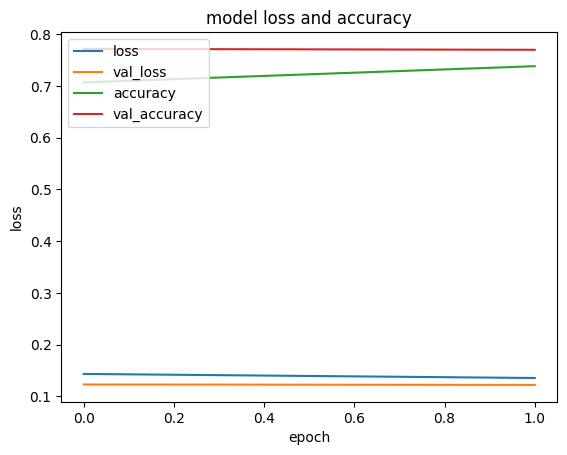

C:\Users\romai\AppData\Local\Temp\ipykernel_14188\3359610714.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [16]:
pred_test = model.predict([X_test_ids, X_test_att]).round()
pred_val = model.predict([X_val_ids, X_val_att]).round()

pred_test = np.asarray(pred_test).astype('int64').reshape((-1,1))
pred_val = np.asarray(pred_val).astype('int64').reshape((-1,1))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss and accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
plt.show()

mlflow.log_metric("auc_score_test", roc_auc_score(y_test, pred_test))
mlflow.log_metric("auc_score_val", roc_auc_score(y_val, pred_val))

mlflow.log_metric("f1_score_test", f1_score(y_test, pred_test))
mlflow.log_metric("f1_score_val", f1_score(y_val, pred_val))

mlflow.log_metric("precision_score_test", precision_score(y_test, pred_test))
mlflow.log_metric("precision_score_val", precision_score(y_val, pred_val))

mlflow.log_metric("recall_score_test", recall_score(y_test, pred_test))
mlflow.log_metric("recall_score_val", recall_score(y_val, pred_val))

mlflow.log_metric("fbeta_score_test", fbeta_score(y_test, pred_test, beta=0.5))
mlflow.log_metric("fbeta_score_val", fbeta_score(y_val, pred_val, beta=0.5))

mlflow.log_metric("accuracy_score_test", accuracy_score(y_test, pred_test))
mlflow.log_metric("accuracy_score_val", accuracy_score(y_val, pred_val))

pickle.dump('BERT', open('BERT.pkl', 'wb'))
time_training = stop - start

if type(tableau_score) == type([]):
    tableau_score.append({
        "Nom du modèle" : "DistillBERT",
        "Temps d'entraînement" : time_training,
        "AUC-score_test" : roc_auc_score(y_test, pred_test),
        "AUC-score_val" : roc_auc_score(y_val, pred_val),
        "F1-score_test" : f1_score(y_test, pred_test),
        "F1-score_val" : f1_score(y_val, pred_val),
        "Précision-score_test" : precision_score(y_test, pred_test),
        "Précision-score_val" : precision_score(y_val, pred_val),
        "Rappel-score_test" : recall_score(y_test, pred_test),
        "Rappel-score_val" : recall_score(y_val, pred_val),
        "F-bêta-score_test" : fbeta_score(y_test, pred_test, beta=0.5),
        "F-bêta-score_val" : fbeta_score(y_val, pred_val, beta=0.5),
        "accuracy-score_test" : accuracy_score(y_test, pred_test,),
        "accuracy-score_val" : accuracy_score(y_val, pred_val)
    })

else:
    list = ["BERT", time_training, roc_auc_score(y_test, pred_test), roc_auc_score(y_val, pred_val), 
            f1_score(y_test, pred_test), f1_score(y_val, pred_val),
            precision_score(y_test, pred_test), precision_score(y_val, pred_val), recall_score(y_test, pred_test), recall_score(y_val, pred_val),
            fbeta_score(y_test, pred_test, beta=0.5), fbeta_score(y_val, pred_val, beta=0.5),
            accuracy_score(y_test, pred_test), accuracy_score(y_val, pred_val)]

    tableau_score = tableau_score.append(pd.Series(list, index = ["Nom du modèle", "Temps d'entraînement", "AUC-score_test", "AUC-score_val", 
                                                                    "F1-score_test", "F1-score_val", "Précision-score_test", "Précision-score_val", "Rappel-score_test", 
                                                                    "Rappel-score_val", "F-bêta-score_test", "F-bêta-score_val", 
                                                                    "accuracy-score_test", "accuracy-score_val"]), ignore_index=True)

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

263/263 [==============================] - 298s 1s/step
Aléatoire: ROC AUC= 0.500
Model DistillBERTROC AUC= 0.770


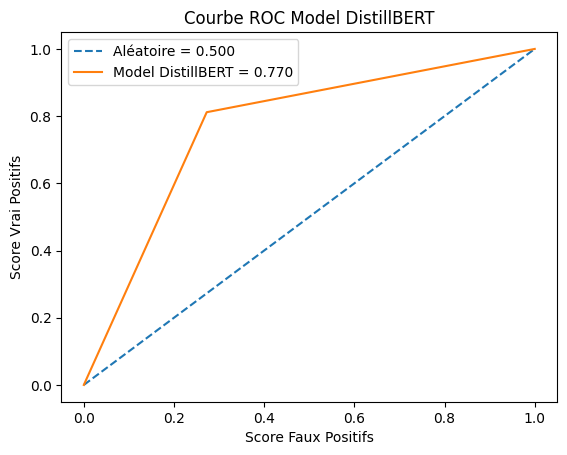

In [17]:
graph_courbe_roc(model, [X_test_ids, X_test_att], y_test, "Model DistillBERT")

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      4179
           1       0.75      0.81      0.78      4221

    accuracy                           0.77      8400
   macro avg       0.77      0.77      0.77      8400
weighted avg       0.77      0.77      0.77      8400



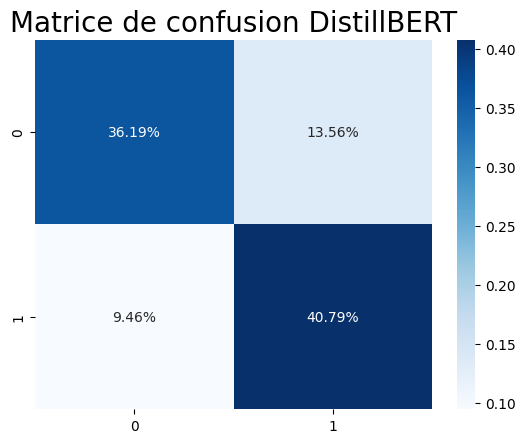

In [18]:
confusion_report_matrix("Matrice de confusion DistillBERT", y_test, pred_test)

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

In [19]:
tableau_score

,Nom du modèle,Temps d'entraînement,AUC-score_test,AUC-score_val,F1-score_test,F1-score_val,Précision-score_test,Précision-score_val,Rappel-score_test,Rappel-score_val,F-bêta-score_test,F-bêta-score_val,accuracy-score_test,accuracy-score_val
0,Régression Logistique Count Lemmatized,6.736087,0.762875,0.762813,0.762875,0.762813,0.762875,0.762813,0.762875,0.762813,0.762875,0.762813,0.762875,0.762813
1,Régression Logistique Count Stemmed,5.005085,0.761500,0.758594,0.761500,0.758594,0.761500,0.758594,0.761500,0.758594,0.761500,0.758594,0.761500,0.758594
2,Régression Logistique TF-IDF Lemmatized,4.726022,0.769625,0.765625,0.769625,0.765625,0.769625,0.765625,0.769625,0.765625,0.769625,0.765625,0.769625,0.765625
3,Régression Logistique TF-IDF Stemmed,4.360262,0.768375,0.764062,0.768375,0.764063,0.768375,0.764062,0.768375,0.764062,0.768375,0.764062,0.768375,0.764062
4,BERT,2564.690594,0.769551,0.769551,0.779877,0.779877,0.750493,0.750493,0.811656,0.811656,0.761977,0.761977,0.769762,0.769762


In [20]:
# tableau_score.to_csv("csv/tableau_score.csv", index=False) 

<div style="background-color : lightgreen; color: black; padding : 5px; border-radius: 5px">
</div>

# Conclusion

Pour améliorer le modèle : optimization du learning rate, choisir un meilleur nombre d'épochs, batchs size, plus de données, le nombre de faux négatifs trés élevé est surement du au traitement éffectuer qui contient des stop-words qui devrait être justement présent pour prédire les sentiments positifs et négatif